In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from scipy.linalg import sqrtm
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from kymatio.torch import Scattering2D
import os
import gc

print(torch.cuda.is_available())

ranges_dict = dict(
    params = {
        0: [4, 6], # ION_Tvir_MIN
        1: [10, 250], # HII_EFF_FACTOR
        },
    images = {
        0: [0, 80], # brightness_temp
        }
    )

True


In [2]:
def load_h5_as_tensor(dir_name='/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5'):
    dataset = Dataset4h5(dir_name, num_image=800, num_redshift=64, HII_DIM=64, rescale=False, dim=2)

    with h5py.File(dir_name) as f:
        # print(f.keys())
        # print(f['params'])
        # print(f['redshifts_distances'])
        los = f['redshifts_distances'][:,-dataset.num_redshift:]

    dataloader = DataLoader(dataset, batch_size=800)
    
    x, c = next(iter(dataloader))
    # print("x.shape =", x.shape)
    # print("c.shape =", c.shape)
    print("x.min() =", x.min())
    print("x.max() =", x.max())
    return x, c, los

In [3]:
# _, c_test, _ = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5')

In [4]:
# print(np.shape(c_test))
# num = 4000
# plt.scatter(c_test[:num,0], c_test[:num,1])

In [5]:
# !rm test.h5

In [6]:
# with h5py.File("test.h5", 'a') as f:
#     num = 8000
#     images = f.create_dataset(
#         'images',
#         shape = (num, 1, 64, 512),
#         maxshape = (None, 1, 64, 512),
#         dtype='float32'
#     )
#     images[:] = np.random.normal(0,1,(num,1,64,512))

#     params = f.create_dataset(
#         'params',
#         shape = (num, 2),
#         maxshape = (None, 2),
#         dtype='float32'
#     )
#     params[:] = np.random.normal(0,1,(num,2))

#     # params = np.random.normal(0,1,(num,2))
#     # f['params'] = params

In [7]:
# from time import time
# import h5py
# import numpy as np

# with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5", 'r') as f:
#     num = 3000
#     print(f['brightness_temp'])
#     print(f['params']['values'])

#     images_start = time()
#     images = np.array(f['brightness_temp'][:num])
#     images_end = time()
#     print(f"images {images.shape} loaded after {images_end-images_start:.3f}s")

#     params_start = time()
#     params = np.array(f['params']['values'][:num])
#     params_end = time()
#     print(f"params {params.shape} loaded after {params_end-params_start:.3f}s")

In [8]:
x0, c0, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5')
x1, c1, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.6-19.037.h5')
x2, c2, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.699-30.h5')
x3, c3, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.477-200.h5')
x4, c4, los = load_h5_as_tensor('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.8-131.341.h5')

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 800 images with idx = range(0, 800)
concurrently loading by 6 max_workers...
pid 119949: images (133, 1, 64, 64) & params (133, 2) loaded after 4.905s & 0.100s
pid 119944: images (134, 1, 64, 64) & params (134, 2) loaded after 6.094s & 0.082s
pid 119948: images (133, 1, 64, 64) & params (133, 2) loaded after 6.299s & 0.017s
pid 119946: images (133, 1, 64, 64) & params (133, 2) loaded after 6.314s & 0.047s
pid 119945: images (134, 1, 64, 64) & params (134, 2) loaded after 6.727s & 0.043s
pid 119947: images (133, 1, 64, 64) & params (133, 2) loaded after 6.820s & 0.024s
images (800, 1, 64, 64) & params (800, 2) concurrently loaded after 6.918s
images transformed after 0.005s
x.min() = tensor(0.)
x.max() = tensor(43.0394)
dataset content: <KeysViewHDF5 ['

In [9]:
print(los.shape)
print(x0.min())
print(x0.max())

(2, 64)
tensor(0.)
tensor(43.0394)


torch.Size([800, 1, 64, 64])


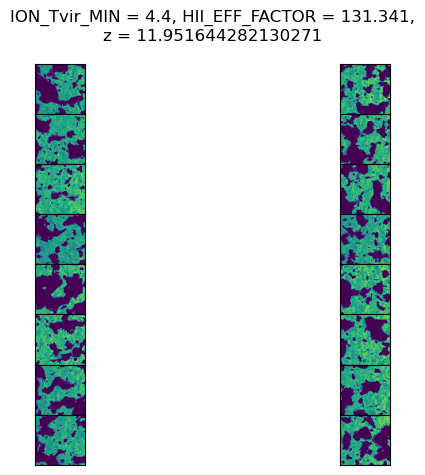

torch.Size([800, 1, 64, 64])


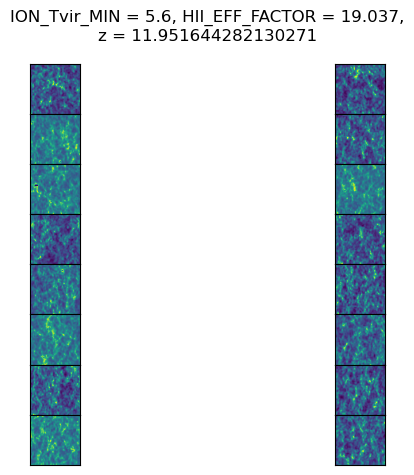

In [10]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot_grid(samples, c, row=8, col=2, idx=0, los=None, savename=None):
    plt.figure()#figsize = (col*3,row*3+1), dpi=300)
    print(samples.shape)
    for i in range(row*col):
        plt.subplot(row,col,i+1)
        if samples.ndim == 5:
            plt.imshow(samples[i,0,:,:,idx])#, vmin=-1, vmax=1)
        elif samples.ndim == 4:
            plt.imshow(samples[i,0,:,:])
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(f"ION_Tvir_MIN = {c[0][0]}, HII_EFF_FACTOR = {c[0][1]},\nz = {los[0,idx]}")
        # plt.show()
    # plt.suptitle('simulations')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    if savename is None:
        plt.show()
    else:
        plt.savefig(savename)
    plt.close()
    gc.collect()
    

plot_grid(x0, c=c0, idx=-1, los=los)
plot_grid(x1, c=c1, idx=-1, los=los)
# plot_grid(x2, c=c2, idx=-1, los=los)
# plot_grid(x3, c=c3, idx=-1, los=los)
# plot_grid(x4, c=c4, idx=-1, los=los)

In [11]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (4*np.pi**2)

    return kbins, Pk

In [12]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
def x2Pk(x):
    Pk_vals_all = []
    for i in range(x.shape[0]):
        density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all
    # Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [13]:
k_vals, Pk_vals_all_0_sim = x2Pk(x0)
k_vals, Pk_vals_all_1_sim = x2Pk(x1)
k_vals, Pk_vals_all_2_sim = x2Pk(x2)
k_vals, Pk_vals_all_3_sim = x2Pk(x3)
k_vals, Pk_vals_all_4_sim = x2Pk(x4)

In [14]:
ls -lth outputs | head

total 864M
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 20:06 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-2006.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 20:04 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-2004.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 20:02 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-2002.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 20:00 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-2000.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 19:58 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-1958.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 19:57 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-1957.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 19:55 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-1955.npy
-rw-r--r--  1 bxia34 pace-jw254 321K Jul 23 19:53 Tvir4.800000190734863-zeta131.34100341796875-N8000-device0-0723-1953.npy
-rw-r

In [15]:
def rescale(x, ranges=ranges_dict['images']):
    x = (x + 1) / 2 * (ranges[0][1]-ranges[0][0]) + ranges[0][0]
    return x
    
def x2Tb(x):
    print('x.shape =', x.shape)
    if x.ndim == 4:
        Tb = x[:,0].mean(axis=1)
    elif x.ndim == 5:
        Tb = x[:,0].mean(axis=(1,2))
    return Tb

In [16]:
x0.ndim

4

torch.Size([200, 1, 64, 64])


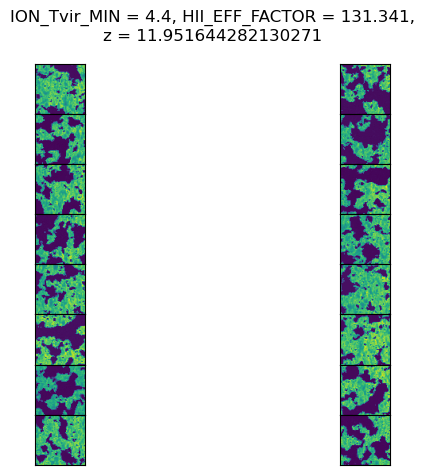

torch.Size([200, 1, 64, 64])


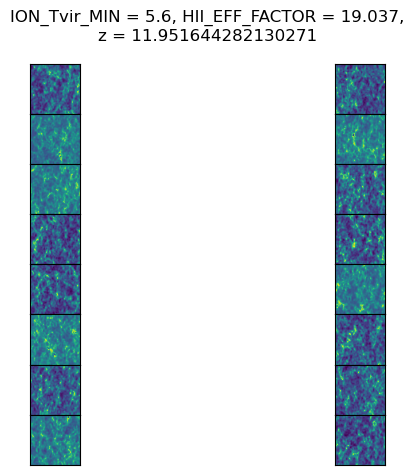

torch.Size([200, 1, 64, 64])


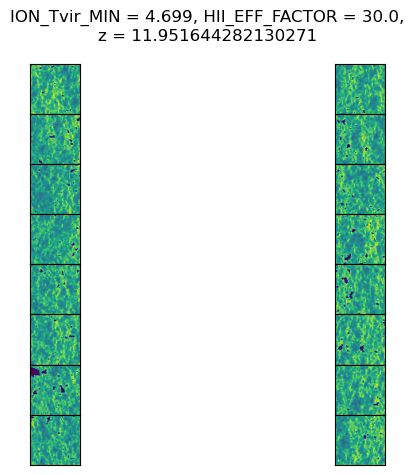

torch.Size([200, 1, 64, 64])


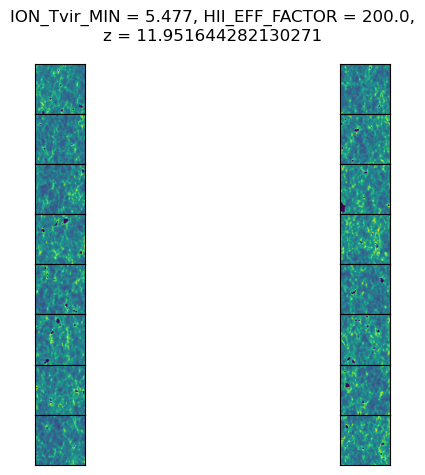

torch.Size([200, 1, 64, 64])


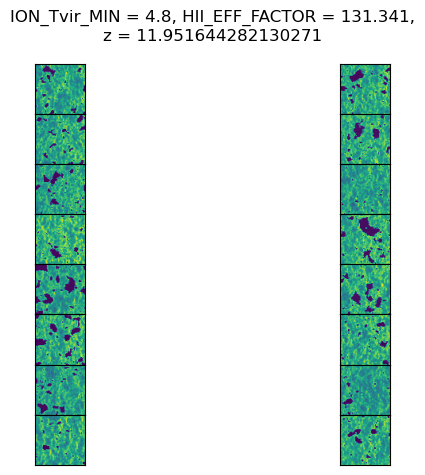

In [17]:
# x_ml = np.load("outputs/0527-1951.npy")
# x_ml = np.load("outputs/test_2_506.npy")
# x_ml = torch.from_numpy(x_ml)
# x_ml = unscale(x_ml)

# num = 3200
# x0_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.400000095367432-zeta131.34100341796875-N{num}.npy")))
# x1_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.599999904632568-zeta19.03700065612793-N{num}.npy")))
# x2_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.698999881744385-zeta30.0-N{num}.npy")))
# x3_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.4770002365112305-zeta200.0-N{num}.npy")))
# x4_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.800000190734863-zeta131.34100341796875-N{num}.npy")))
def load_x_ml(fname_pattern):
    # num = 7200
    x_ml = []
    fnames = [fname for fname in os.listdir("outputs") if fname_pattern in fname]
    for fname in fnames:
        data = np.load(os.path.join("outputs", fname))
        # print(fname)
        # print(data.shape)
        x_ml.append(data)
    x_ml = np.concatenate(x_ml, axis=0)
    x_ml = rescale(x_ml)
    x_ml = torch.from_numpy(x_ml)
    return x_ml

num_image = 8000
x0_ml = load_x_ml(f"Tvir4.400000095367432-zeta131.34100341796875-N{num_image}-device")
x1_ml = load_x_ml(f"Tvir5.599999904632568-zeta19.03700065612793-N{num_image}-device")
x2_ml = load_x_ml(f"Tvir4.698999881744385-zeta30.0-N{num_image}-device")
x3_ml = load_x_ml(f"Tvir5.4770002365112305-zeta200.0-N{num_image}-device")
x4_ml = load_x_ml(f"Tvir4.800000190734863-zeta131.34100341796875-N{num_image}-device")

plot_grid(x0_ml, c=c0, idx=-1, los=los)
plot_grid(x1_ml, c=c1, idx=-1, los=los)
plot_grid(x2_ml, c=c2, idx=-1, los=los)
plot_grid(x3_ml, c=c3, idx=-1, los=los)
plot_grid(x4_ml, c=c4, idx=-1, los=los)

In [18]:
def plot_global_signal(x_pairs, params, sigma_level=68.27, alpha=0.2):
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200)
    interval = 10
    for i, (x0, x1) in enumerate(x_pairs):
        # print(Tb0.shape)
        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        Tb0_perc = np.percentile(Tb0, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(los[0], Tb0_perc[0], Tb0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        # ax[0].fill_between(los[0], np.percentile(Tb1, 100-sigma_level, axis=0), np.percentile(Tb1, sigma_level, axis=0), alpha=alpha/3, facecolor=f"C{i}", edgecolor='black', hatch='/')

        Tb1_perc = np.percentile(Tb1, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - Tb1_perc[0]
        yerr_upper = Tb1_perc[1] - y1
        ax[0].errorbar(los[0][::interval], y1[::interval], yerr=[yerr_lower[::interval], yerr_upper[::interval]], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')

        ax[0].plot(los[0], y0, linestyle=':', c=f"C{i}")#, label='sim')
        # ax[0].plot(los[0], y1, lw=2, linestyle=':', c=f"C{i}")#, label='diffusion')
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(los[0], (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = 0.5*(Tb0_perc[1]-Tb0_perc[0])
        ax[2].plot(los[0], (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")
        
        # print(np.max((Tb1_perc[1]-Tb1_perc[0])/(Tb0_perc[1]-Tb0_perc[0])))
        ax[3].plot(los[0], (Tb1_perc[1]-Tb1_perc[0])/2/sigma-1, c=f"C{i}")

    # ax[0].set_xscale('log')
    # ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\langle T_b \rangle$ [mK]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    # solid = Line2D([0],[0], color='k', lw=1, linestyle='-', label='sim')
    # dashed = Line2D([0],[0], color='k', lw=1, linestyle='--', label='ml')
    # legend0 = ax[0].legend(handles=[solid,dashed])
    
    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['sim', 'ml'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_title(r"global temperature")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    # ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('Redshift')
    # xs = ax[1].secondary_xaxis('top')
    # xs.set_xticklabels([])
    # xs.set_xticks([],[])
    ax[1].grid()
    
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()

    # ax[1].legend()

    # ax[2].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    
    ax[3].set_xlabel('Redshift')
    # ax[2].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    ax[3].grid()
    
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")

    # ax[1].set_yscale('log')
    # ax[2].set_yscale('log')
    # ax[3].set_yscale('log')

        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()

x.shape = torch.Size([800, 1, 64, 64])
x.shape = torch.Size([200, 1, 64, 64])
x.shape = torch.Size([800, 1, 64, 64])
x.shape = torch.Size([200, 1, 64, 64])
x.shape = torch.Size([800, 1, 64, 64])
x.shape = torch.Size([200, 1, 64, 64])
x.shape = torch.Size([800, 1, 64, 64])
x.shape = torch.Size([200, 1, 64, 64])
x.shape = torch.Size([800, 1, 64, 64])
x.shape = torch.Size([200, 1, 64, 64])


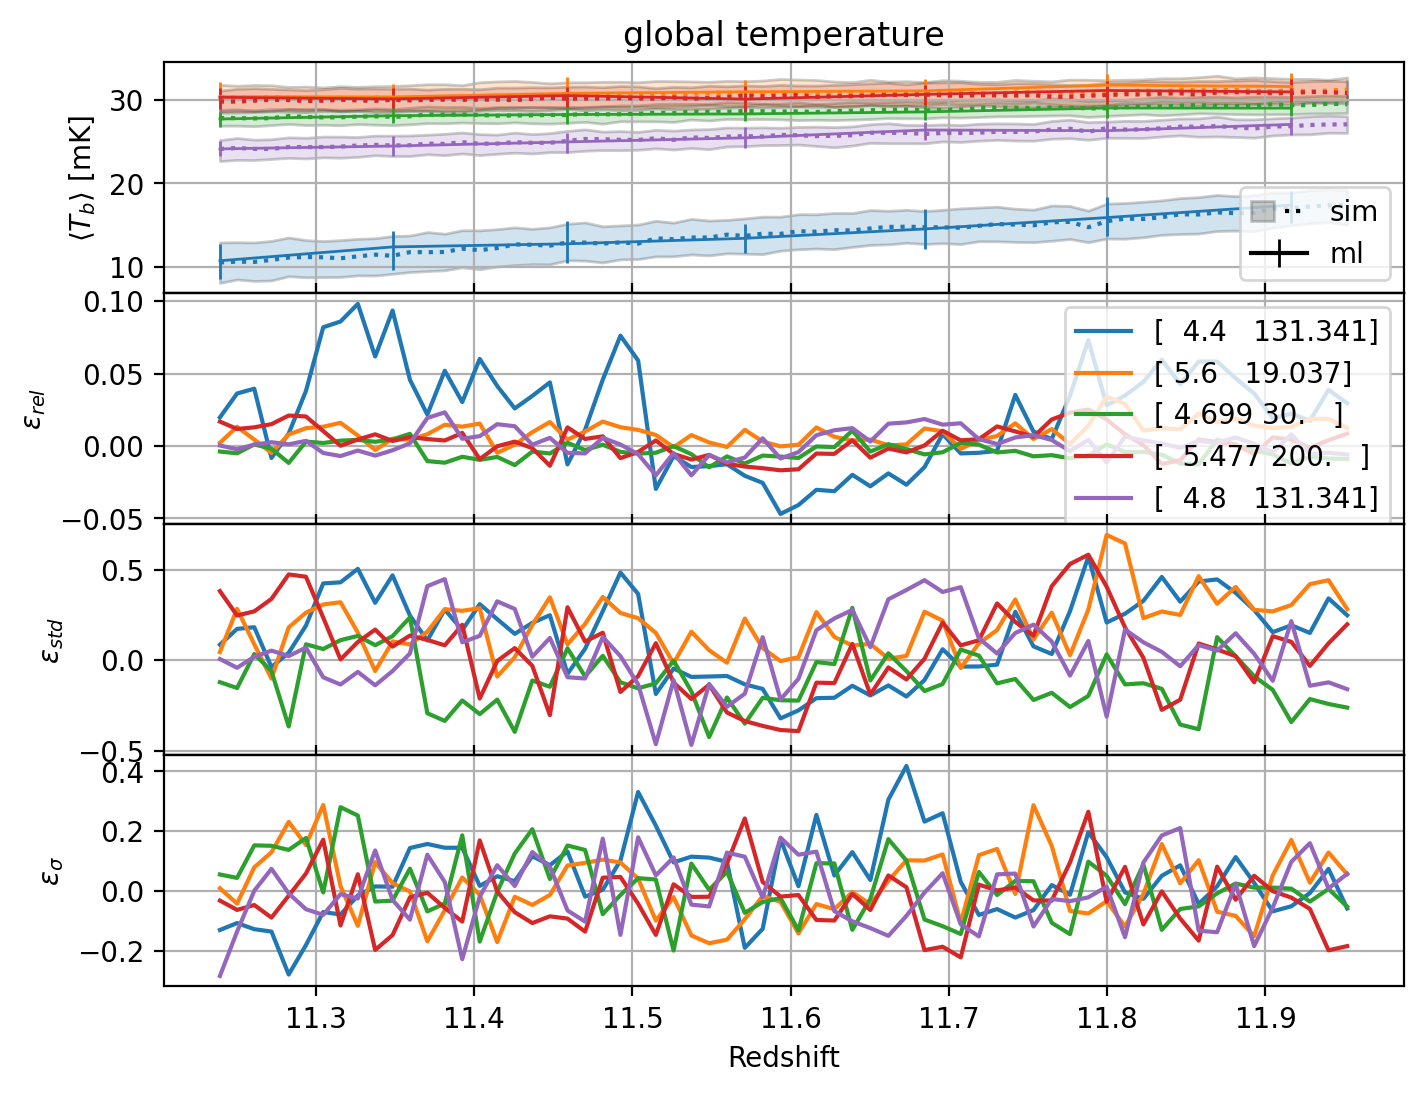

In [19]:
plot_global_signal(
    [
        (x0,x0_ml),
        (x1,x1_ml),
        (x2,x2_ml),
        (x3,x3_ml),
        (x4,x4_ml),
        ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        c3[0], 
        c4[0],
    ],   
    )

In [20]:
# sigma_level = 68

# for i in range(Pk_vals_all_0_ml.shape[0]):
#     plt.plot(k_vals, Pk_vals_all_0_ml[i], lw=0.1)

# plt.fill_between(k_vals, np.percentile(Pk_vals_all_0_ml, sigma_level, axis=0), np.percentile(Pk_vals_all_0_ml, 100-sigma_level, axis=0), alpha=1, facecolor=f"C0", edgecolor='black')#, hatch='/')
# print('i =', i)
# plt.yscale('log')
# # plt.xscale('log')

In [21]:
def plot_power_spectrum(Pk_pairs, params, sigma_level=68.27, alpha=0.2, redshift=None):
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200)
    for i, (Pk0, Pk1) in enumerate(Pk_pairs):
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)

        # k_vals_all = np.array(k_vals_all)
        # print(k_vals_all.shape)
        # print(Pk_vals_all.shape)
            # plt.subplot(2, 1, 2)
            # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
            # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
            # plt.xlabel('k [h/Mpc]')
            # plt.ylabel('Power')
            # plt.title('Normalized Power Spectrum')
            # # plt.legend()
            # plt.grid(True)
        # sigma_level = 0
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk0, axis=0), 'b--', lw=1)
        Pk0_perc = np.percentile(Pk0, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(k_vals, Pk0_perc[0], Pk0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk1, axis=0), 'r--', lw=1)
        # ax[0].fill_between(k_vals, np.percentile(Pk1, 100-sigma_level, axis=0), np.percentile(Pk1, sigma_level, axis=0), alpha=alpha/3, facecolor=f"C{i}", edgecolor='black', hatch='/')

        ax[0].plot(k_vals, y0, linestyle=':', c=f"C{i}")#, label='sim')
        # line_sim = (line_sim, Patch(facecolor='black', edgecolor='none', alpha=alpha))
        # 添加自定义图例
        # ax[0].legend(legend_elements, ['Solid line with fill_between'], handler_map={tuple: HandlerTuple(ndivide=None)})

        Pk1_perc = np.percentile(Pk1, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - Pk1_perc[0]
        yerr_upper = Pk1_perc[1] - y1
        ax[0].errorbar(k_vals, y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')
        
        # plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
        # plt.plot(k_vals_all_sim.mean(axis=0), Pk0.mean(axis=0), 'k-', lw=1, label="simulations' mean")
        # plt.plot(k_vals, np.abs(y1-y2)/y2, 'b-', label='diffusion')
        ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = 0.5*(Pk0_perc[1]-Pk0_perc[0])
        ax[2].plot(k_vals, (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

        ax[3].plot(k_vals, (Pk1_perc[1]-Pk1_perc[0])/2/sigma-1, c=f"C{i}")

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
        # plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
        # plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
    ax[0].grid()
    
    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['sim', 'ml'], handler_map={tuple: HandlerTuple(ndivide=None)})

    
    # solid = Line2D([0],[0], color='k', linestyle='-', label='sim')
    # solid = line_sim
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[solid,dashed])
    # dashed = Line2D([0],[0], color='k', linestyle='--', label='ml', marker='+')
    # legend0 = ax[0].legend(handles=[line_sim,dashed])

    ax[0].set_title(r"power spectrum of $T_b$ at z = "+f"{los[0].mean():.2f}")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('k [Mpc$^{-1}$]')
    ax[1].grid()
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()

    ax[2].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    # ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax[3].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[3].grid()
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])


    # xs.set_xticks([])
    # xs = ax[1].secondary_xaxis('top')
    # ax[2].legend()
        # plt.plot(k_vals, , 'r-', label='diffusion')

        # plt.tight_layout()
        # plt.setp(ax[0].get_xticklabels(), visible=True)
        # ax[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.subplots_adjust(hspace=0)
    # plt.grid()
        # plt.show()
    # plt.suptitle("test title")
    # plt.tight_layout()


In [34]:
k_vals, Pk_vals_all_0_ml = x2Pk(x0_ml)
k_vals, Pk_vals_all_1_ml = x2Pk(x1_ml)
k_vals, Pk_vals_all_2_ml = x2Pk(x2_ml)
k_vals, Pk_vals_all_3_ml = x2Pk(x3_ml)
k_vals, Pk_vals_all_4_ml = x2Pk(x4_ml)

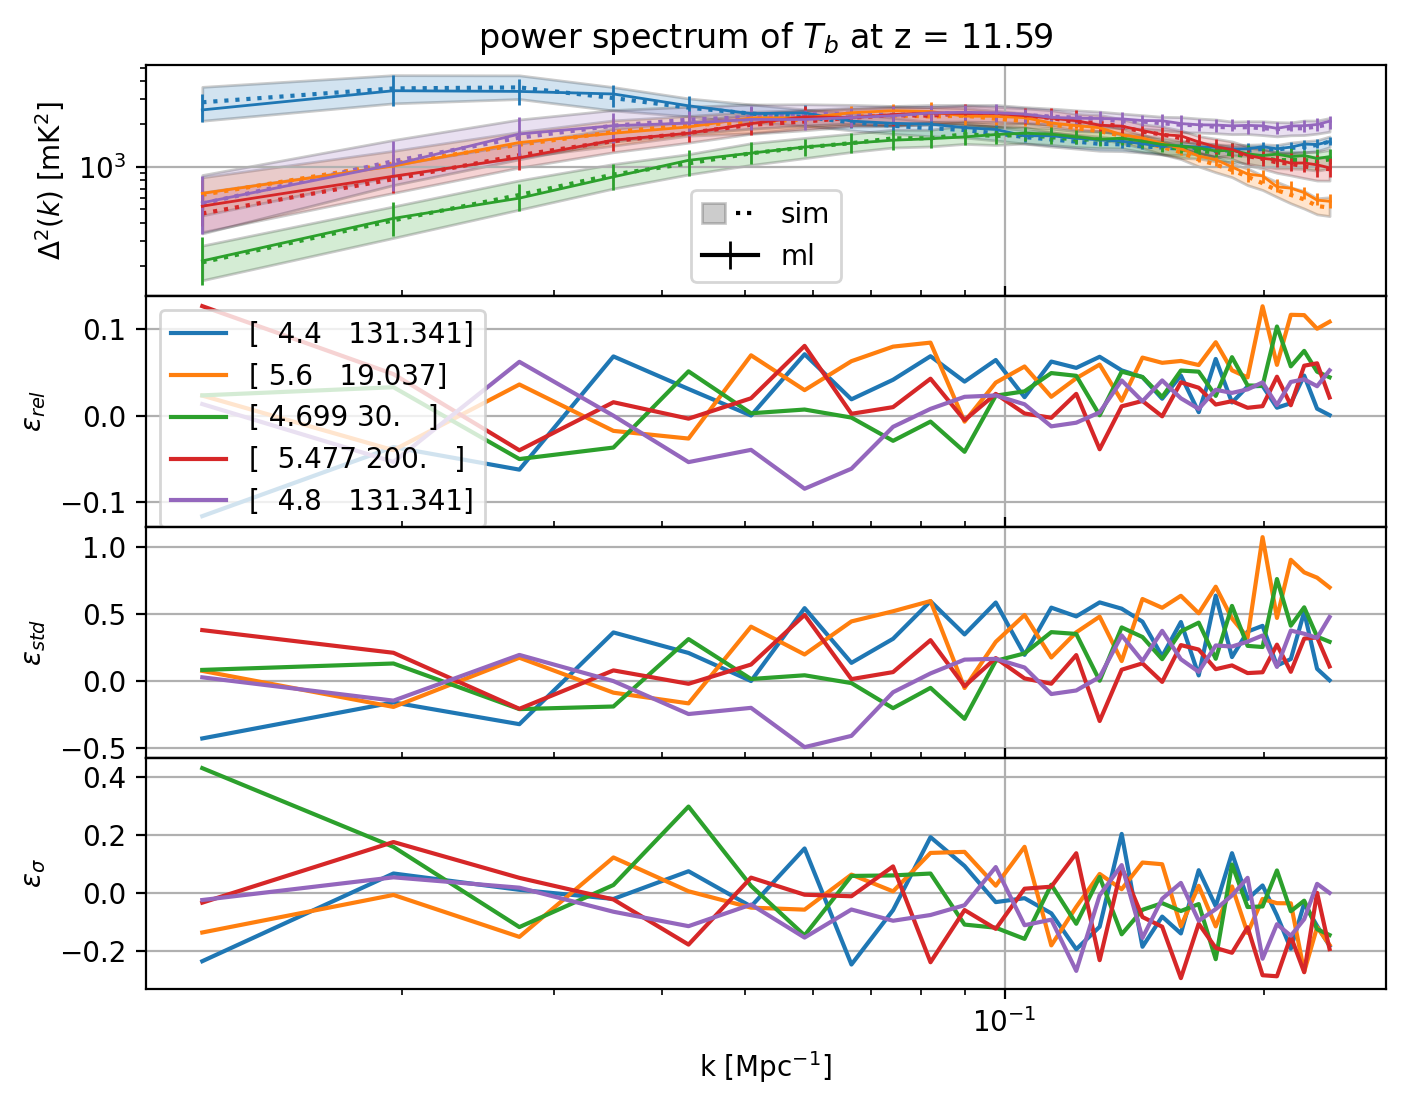

In [35]:
plot_power_spectrum(
    [
        (Pk_vals_all_0_sim, Pk_vals_all_0_ml), 
        (Pk_vals_all_1_sim, Pk_vals_all_1_ml),
        (Pk_vals_all_2_sim, Pk_vals_all_2_ml), 
        (Pk_vals_all_3_sim, Pk_vals_all_3_ml),
        (Pk_vals_all_4_sim, Pk_vals_all_4_ml),
    ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        c3[0], 
        c4[0],
    ]
    )
# plt.grid()
# plot_power_spectrum(Pk_vals_all_diffusion, Pk_vals_all_diffusion)

In [36]:
x0.shape

torch.Size([800, 1, 64, 64])

In [37]:
x0.device

device(type='cpu')

In [38]:
# print(abs((1,-2,3)))

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def sort_S2_by_l(S2, jthetas, L):
    # print("S2.shape =", S2.shape)
    S2_sorted = np.empty((L, S2.shape[0], S2.shape[1]//L))
    jthetas_sorted = np.empty((L, S2.shape[1]//L, 2, 2))
    # jthetas_sorted = [[]]*L
    num_updated = np.zeros(L, dtype=int)

    # print("jthetas =", jthetas)
    for i, jtheta in enumerate(jthetas):
        index = (jtheta[1][1]-jtheta[1][0]) % L
        # print("index =", index)
        # print("num_updated =", num_updated)
        S2_sorted[index, :, num_updated[index]] = S2[:,i]
        # print("sort_S2_by_l", jthetas_sorted[index*L+num_updated[index]], np.array(jtheta))
        jthetas_sorted[index, num_updated[index]][0] = jtheta[0]
        jthetas_sorted[index, num_updated[index]][1] = jtheta[1]
        # print("S2_sorted[:, index*L+num_updated[index]] =", S2_sorted[:, index*L+num_updated[index]])
        # jthetas_sorted[index] = jtheta
        # print("jtheta =", jtheta)
        # print("jthetas_sorted.shape =", jthetas_sorted.shape)
        # print("left =", jthetas_sorted[index*L+num_updated[index],:])
        # print("right =", np.array(jtheta))
        # jthetas_sorted[index*L+num_updated[index],:] = np.array(jtheta)
        # print("index, S2_sorted.shape =", index, np.shape(S2_sorted))
        num_updated[index] += 1
    # print("index*L+num_updated[index]", index*L+num_updated[index])
    # print("i =", i)
    # print("sort_S2_by_l, num_updated =", num_updated)

    S2_sorted = np.array(S2_sorted)
    # print("S2_sorted.shape", S2_sorted.shape)
    # print("S2_sorted", S2_sorted)
    jthetas_sorted = np.array(jthetas_sorted)
    # print('sort_S2_by_l S2_sorted.shape',S2_sorted.shape)
    # print('sort_S2_by_l jthetas_sorted.shape', jthetas_sorted.shape)
    return S2_sorted, jthetas_sorted


def calculate_sorted_S2(x, S, J, L, jthetas):
    S_all = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))
    # print("calculate_sorted_S2, S2.shape =", S_all.shape)
    # print("calculate_sorted_S2, jthetas.shape =", jthetas.shape)
    # print("calculate_sorted_S2, jthetas[21:41] =", jthetas[21:41])
    # print("calculate_sorted_S2, jthetas[-1] =", jthetas[-1])

    ############################################################
    for j1 in range(J-1):
        for j2 in range(j1+1, J):
            # if j2>j1:
            # print("j1", j1, "j2", j2)
            index = [jtheta[0] == (j1,j2) for jtheta in jthetas]
            # print(index)
            # print(jthetas[index])
            # cache = S2[:,index]
            # print(index)
            if (j1,j2) == (0,1):
                S2 = S_all[:,index]
                jthetas_2 = np.array(jthetas[index])
                # index_reduced = index
            else:
                S2 = np.concatenate((S2, S_all[:,index]), axis = 1)
                jthetas_2 = np.concatenate([jthetas_2, np.array(jthetas[index])], axis = 0)
                # index_reduced = np.concatenate((index_reduced, index))
    ############################################################

    # index = 1+L*J
    # S2 = S_all[:,index:]
    # jthetas_2 = jthetas[index:]
    # print("calculate_reduced_S2 S2.shape", S2.shape)
    # print("calculate_sorted_S2 jthetas_2.shape", jthetas_2.shape)
    # print("calculate_sorted_S2 jthetas_2[:20]", jthetas_2[:20])
    # print(jthetas_reduced[:3])

    S2_sorted, jthetas_sorted = sort_S2_by_l(S2, jthetas_2, L)
    # print(index_reduced.shape)
    return S2_sorted, jthetas_sorted

def calculate_reduced_S2(x_pairs, params, J=5, L=4, M=64, N=64):
    S2_reduced_list = []
    jthetas_reduced_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        # get jthetas and S
        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            for dicts in S(x0.to(device)):
                jthetas.append([dicts['j'], dicts['theta']])
            jthetas = np.array(jthetas)
            S = Scattering2D(J, (M, N), L=L).to(device)
            # print("type(dicts[j])", type(dicts['j']), dicts['j'])
        # print("plot_scattering_transform_2 jthetas.shape", jthetas.shape)
        # print(jthetas[0], jthetas[1], jthetas[160])
        S2_reduced_0, jthetas_reduced_0 = calculate_sorted_S2(x0, S, J, L, jthetas)
        S2_reduced_1, jthetas_reduced_1 = calculate_sorted_S2(x1, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        S2_reduced_list.append((S2_reduced_0, S2_reduced_1))
        jthetas_reduced_list.append((jthetas_reduced_0, jthetas_reduced_1))

    return S2_reduced_list, jthetas_reduced_list

In [40]:
# S = Scattering2D(5, (64,64), L=4, out_type='list').to(device)
# jthetas = []
# for dicts in S(x0.to(device)):
#     jthetas.append([dicts['j'], dicts['theta']])
# jthetas = np.array(jthetas)
# S = Scattering2D(5, (64,64), L=4).to(device)

# x = torch.randn((800,1,64,64))
# Sx = S(x.to(device))
# print(Sx.shape)
# S_all = np.mean(Sx[:,0].cpu().numpy(), axis=(2,3))
# print(S_all.shape)
# S0 = S_all[:,0]
# print(S0.shape)
# plt.hist(S0, histtype='step', label='S0')
# plt.hist(x.mean(axis=(1,2,3)), histtype='step', label='x.mean')
# plt.hist(np.median(x, axis=(1,2,3)), histtype='step', label='x.median')
# plt.legend()
# plt.show()

In [41]:
# S = Scattering2D(5, (64,64), L=4, out_type='list').to(device)
# jthetas = []
# for dicts in S(x0.to(device)):
#     jthetas.append([dicts['j'], dicts['theta']])
# jthetas = np.array(jthetas)
# print(jthetas)

In [42]:
# S2_reduced, jthetas_reduced = calculate_reduced_S2(
#     [
#         (x0,x0_ml),
#         (x1,x1_ml),
#         (x2,x2_ml),
#         # (x3,x3_ml),
#         # (x4,x4_ml),
#         ],
#     params = [
#         c0[0], 
#         c1[0],
#         c2[0], 
#         # c3[0], 
#         # c4[0],
#     ],   
# )
# print(np.shape(S2_reduced))
# print(np.shape(jthetas_reduced))
# # print(S2_reduced.shape, jthetas_reduced.shape)
# print(jthetas_reduced[0])

In [43]:
def average_single_S2_over_l(S2, jthetas, L=4):
    # print("average_single_S2_over_l, shape =", S2.shape, jthetas.shape)
    S2_reshape = np.array(np.array_split(S2, S2.shape[2]//L, axis=2))
    # jthetas_reshape = jthetas.reshape(jthetas.shape[0],jthetas.shape[1]//L, L,jthetas.shape[2],jthetas.shape[3])
    jthetas_reshape = np.array(np.array_split(jthetas, jthetas.shape[1]//L, axis=1))
    # print("average_single_S2_over_l, shape =", S2_reshape.shape, jthetas_reshape.shape)
    # print("---"*30)
    # print(jthetas_reshape[0])
    # print("---"*30)
    S2_average = np.average(S2_reshape, axis=3)
    # jthetas_average = np.average(jthetas_reshape, axis=2)
    jthetas_average = jthetas_reshape[:,:,0,0,:]
    # print(S2_average.shape, jthetas_average.shape)
    # print(jthetas_average)
    # print("---"*30)
    S2_transpose = S2_average.transpose(2,1,0)
    # print(S2_transpose.shape)
    # print("---"*30)
    S2_combine = S2_transpose.reshape(S2_transpose.shape[0], -1)
    # print(S2_combine.shape)
    # print("---"*30)
    j1j2 = jthetas_average.transpose(1,0,2).reshape(-1, 2)
    # j1j2 = np.tile(jthetas_average, (S2_combine.shape[1]//jthetas_average.shape[0],1))
        # S2_average.append(())
    return S2_combine, j1j2.astype(int)

def average_S2_over_l(x_pairs, params, J, L, M, N):

    S2_list, jthetas_list = calculate_reduced_S2(x_pairs, params, J, L, M, N)

    S2_average = []
    j1j2_average = []
    for i in range(len(S2_list)):
        S2_sim = S2_list[i][0]
        jthetas_sim = jthetas_list[i][0]
        S2_combine_sim, j1j2_sim = average_single_S2_over_l(S2_sim, jthetas_sim, L)

        S2_ml = S2_list[i][1]
        jthetas_ml = jthetas_list[i][1]
        S2_combine_ml, j1j2_ml = average_single_S2_over_l(S2_ml, jthetas_ml, L)

        S2_average.append((S2_combine_sim, S2_combine_ml))
        j1j2_average.append((j1j2_sim, j1j2_ml))
    return np.array(S2_average), np.array(j1j2_average)

    # print(S2)
# S2, j1j2 = average_S2_over_l(S2_reduced, jthetas_reduced)
# print(np.shape(S2), np.shape(j1j2))

/scratch/805136/ipykernel_119752/457225549.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


S2.shape, j1j2.shape = (5, 2) (5, 2, 40, 2)


/scratch/805136/ipykernel_119752/3922154762.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(S2_average), np.array(j1j2_average)


ValueError: operands could not be broadcast together with shapes (800,40) (200,40) 

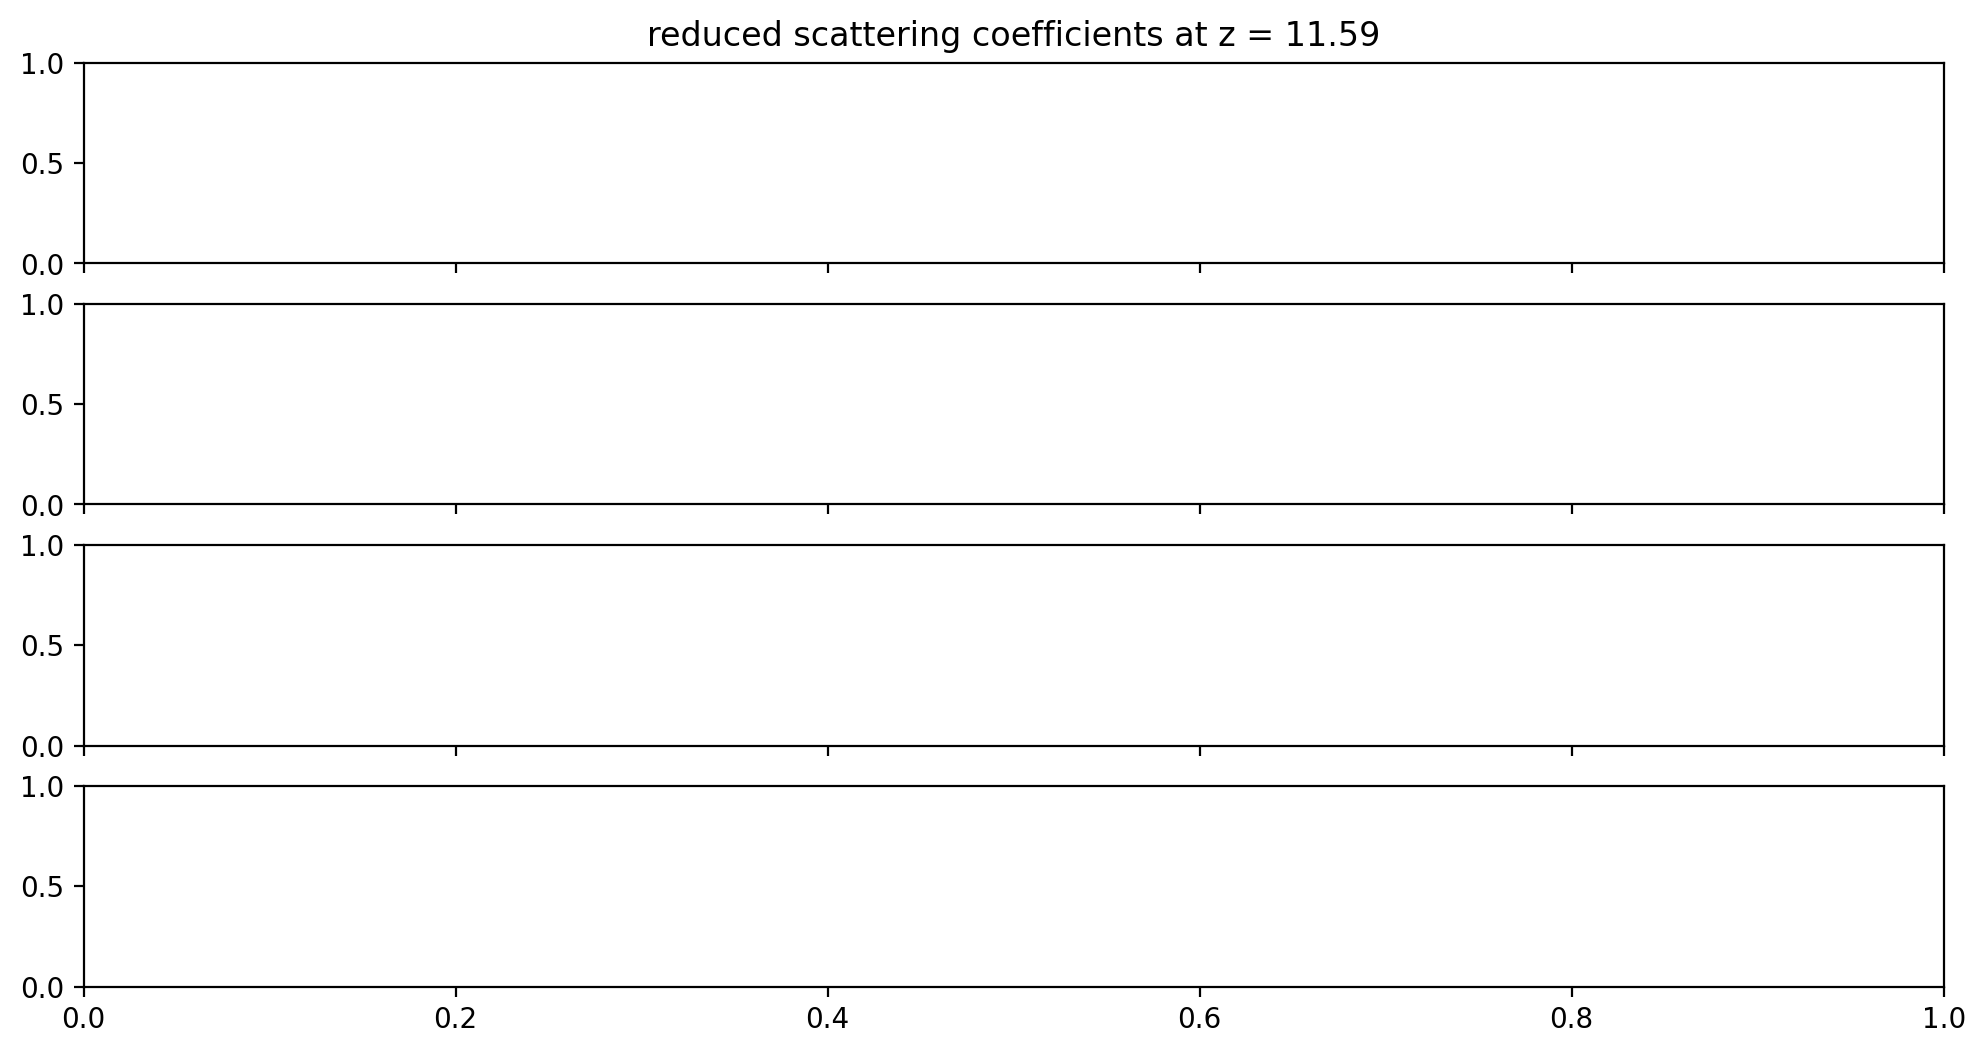

In [45]:
def plot_scattering_transform_2(x_pairs, params, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64):
    # S2_reduced, jthetas_reduced = calculate_reduced_S2(x_pairs, params, J, L, M, N)
    S2, j1j2 = average_S2_over_l(x_pairs, params, J, L, M, N)
    print("S2.shape, j1j2.shape =", S2.shape, j1j2.shape)
    # plt.figure(dpi=200, figsize=(12,4))
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(12,6), dpi=200)
    ax[0].set_title(f"reduced scattering coefficients at z = {los[0].mean():.2f}")
    # S2 = S2[..., :20]
    print("S2.min() =", S2.min())
    S2 = np.log10(S2)
    # j1j2 = j1j2[..., :S2.shape[3], :]
    j1j2 = j1j2[0,0]
    for i in range(len(S2)):
        S2_sim = S2[i][0]
        S2_ml = S2[i][1]

        y0 = np.median(S2_sim, axis=0)
        y1 = np.median(S2_ml, axis=0)
        # print(y0.shape)
        ax[0].plot(np.arange(y0.shape[0]), y0, lw=1, c=f"C{i}", linestyle=':')
        # plt.plot(np.median(S2_ml, axis=0), lw=1)

        S2_sim_perc = np.percentile(S2_sim, [100-sigma_level, sigma_level], axis=0)
        # S2_ml_perc = np.percentile(S2_ml, [100-sigma_level, sigma_level], axis=0)
        ax[0].fill_between(np.arange(S2_sim.shape[1]), S2_sim_perc[0], S2_sim_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # plt.fill_between(np.arange(S2_ml.shape[1]), S2_ml_perc[0], S2_ml_perc[1], alpha=alpha)

        S2_ml_perc = np.percentile(S2_ml, [100-sigma_level, sigma_level], axis=0)
        yerr_lower = y1 - S2_ml_perc[0]
        yerr_upper = S2_ml_perc[1] - y1
        ax[0].errorbar(np.arange(y1.shape[0]), y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')

        ax[1].plot(np.arange(y0.shape[0]), ((y1-y0)/y0), label=f'{np.array(params[i])}', c=f"C{i}")

        sigma = (S2_sim_perc[1]-S2_sim_perc[0])/2
        ax[2].plot(np.arange(y0.shape[0]), (y1-y0)/sigma, label=f'{np.array(params[i])}', c=f"C{i}")

        # ax[3].plot(np.arange(y0.shape[0]), (S2_sim_perc[1]-S2_sim_perc[0])/sigma-1, c=f"C{i}")
        ax[3].plot(np.arange(y0.shape[0]), (S2_ml_perc[1]-S2_ml_perc[0])/2/sigma-1, c=f"C{i}")

    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # 创建自定义图例条目
    legend_elements = [
        (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
        (legend_line2),
    ]
    # 添加自定义图例
    ax[0].legend(legend_elements, ['sim', 'ml'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_ylabel(r'$\log{S_2}$')
    ax[0].grid()
    j1j2_period = j1j2.shape[0]//L

    # plt.text()
    ax[0].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[1].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[1].get_ylim()[0], ax[1].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[2].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[2].get_ylim()[0], ax[2].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[3].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[3].get_ylim()[0], ax[3].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')

    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylabel(r'$\epsilon_{rel}$')

    # ax[2].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    # ax[2].set_xlabel(r'$(j_1,\ j_2)$')
    ax[2].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[2].set_ylabel(r'$\epsilon_{std}$')
    # print(ax[2].get_xticks())
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])
    # ax[2].set_xlim((0,19))

    ax[3].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    ax[3].set_xlabel(r'$(j_1,\ j_2)$')
    ax[3].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[3].set_ylabel(r'$\epsilon_{\sigma}$')
    # print(ax[2].get_xticks())
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])
    # ax[3].set_xlim((0,19))

    for i in range(L):
        if i*j1j2_period < ax[3].get_xlim()[1]:
            ax[3].text(x=i*j1j2_period, y=0.02+ax[3].get_ylim()[0], s=r"$(l_2-l_1)\%L$="+f"{i}")

    plt.subplots_adjust(hspace=0)

plot_scattering_transform_2(
    [
        (x0,x0_ml),
        (x1,x1_ml),
        (x2,x2_ml),
        (x3,x3_ml),
        (x4,x4_ml),
    ],
    params = [
        c0[0], 
        c1[0],
        c2[0], 
        c3[0], 
        c4[0],
    ],
    )

In [71]:
def calculate_S0_and_sorted_S1(x, S, J, L, jthetas):
    S_all = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))
    # plt.plot(np.log10(S_all.mean(axis=0)))
    # print("S_all.shape =", S_all.shape)
    # S0 = S_all[]
    S0 = S_all[:,0]
    S1 = S_all[:,1:J*L+1]
    # print("S1.shape =", S1.shape)
    S1_splited = np.array(np.array_split(S1, J, axis=-1))
    # print("S1_splited.shape =", S1_splited.shape)
    S1_averaged = np.mean(S1_splited, axis=-1).transpose()
    return S0, S1_averaged

def calculate_S0_and_reduced_S1(x_pairs, params, J, L, M, N):
    S0_list = []
    S1_reduced_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        # get jthetas and S
        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            for dicts in S(x0.to(device)):
                jthetas.append([dicts['j'], dicts['theta']])
            jthetas = np.array(jthetas)
            S = Scattering2D(J, (M, N), L=L).to(device)
            # print("type(dicts[j])", type(dicts['j']), dicts['j'])
        # print("plot_scattering_transform_2 jthetas.shape", jthetas.shape)
        # print(jthetas[0], jthetas[1], jthetas[160])
        S0_0, S1_0 = calculate_S0_and_sorted_S1(x0, S, J, L, jthetas)
        S0_1, S1_1 = calculate_S0_and_sorted_S1(x1, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        
        S0_list.append((S0_0, S0_1))
        S1_reduced_list.append((S1_0, S1_1))

    return np.array(S0_list), np.array(S1_reduced_list)

# result = calculate_S0_and_reduced_S1(
#     [
#         (x0,x0_ml),
#         (x1,x1_ml),
#         (x2,x2_ml),
#         # (x3,x3_ml),
#         # (x4,x4_ml),
#     ],
#     params = [
#         c0[0], 
#         c1[0],
#         c2[0], 
#         # c3[0], 
#         # c4[0],
#     ],
#     J=5,L=4,M=64,N=64,
#     )

# print(result[0].shape, result[1].shape)

In [72]:
# test = np.array([-100, -10, -2, -1, -0.1, 0.1, 1, 2, 10, 100])
# print(test)
# print(np.where(test >= 0, 1, -1))
# logtest = np.where(test >= 0, 1, -1) * np.log10(abs(test))
# # logtest = [1 if num>0 else -1 for num in test]*np.log(abs(test))
# print(logtest)
# # plt.plot(np.arange(len(test)), test, label='test')
# plt.plot(np.arange(len(test)), logtest, label='logtest')
# plt.legend()
# plt.show()
# test = np.random.normal(0,1,(4,4))
# print(test)
# wheretest = np.where(test>=0, 1,-1)*abs(test)
# print(wheretest)
# print(test==wheretest)

/scratch/788167/ipykernel_51678/3551430250.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)
/scratch/788167/ipykernel_51678/457225549.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


shapes of S0, S1, and S2: (1, 2, 800) (1, 2, 800, 5) (1, 2, 800, 40)
S_all.shape = (1, 2, 800, 46) S0[:,0].shape = (1, 800) S1[:,0].shape = (1, 800, 5) S2[:,0].shape = (1, 800, 40)
S0[:,0].min() = 5.1405573 S1[:,0].min() = 0.6403344 S2[:,0].min() = 0.05043002683669329
S0[:,1].min() = 4.6004667 S1[:,1].min() = 0.6388178 S2[:,1].min() = 0.048643046990036964


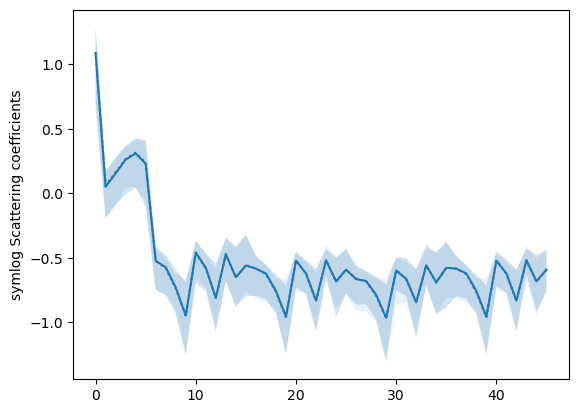

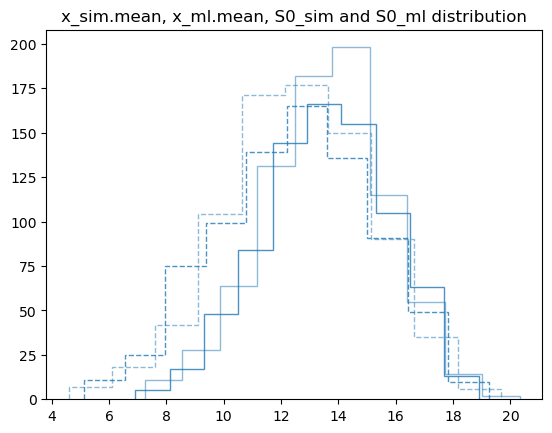

FSD_list = [0.00255013]


In [73]:
def calculate_FSD(S_sim, S_ml):
    # print("S_sim.shape, S_ml.shape =", S_sim.shape, S_ml.shape)
    # S_sim = np.log10(S_sim)
    # S_ml = np.log10(S_ml)

    mu1 = np.mean(S_sim, axis=0)
    mu2 = np.mean(S_ml, axis=0)
    ssdiff = np.sum((mu1-mu2)**2)
    # print("S_sim.shape =", S_sim.shape)
    # print("mu1.shape =", mu1.shape)

    sigma1 = np.cov(S_sim, rowvar=False)
    sigma2 = np.cov(S_ml, rowvar=False)
    # covmean = np.sqrt(sigma1@sigma2.transpose())
    # covmean = np.sqrt(sigma1*sigma2)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    # print("sigma1.shape =", sigma1.shape)
    # print("covmean.shape =", covmean.shape)

    if np.iscomplexobj(covmean):
        print("iscomplexobj")
        covmean = covmean.real
    
    # print("ssdiff =", ssdiff)
    # print("np.trace(sigma1 + sigma2 - 2 * covmean) =", np.trace(sigma1 + sigma2 - 2 * covmean))
    fid = ssdiff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

def calculate_FSD_list(x_pairs, params, J=5, L=4, M=64, N=64):
    # S2_reduced_list = []
    # jthetas_reduced_list = []
    # for i, (x0, x1) in enumerate(x_pairs):
    #     # get jthetas and S
    #     if i == 0:
    #         S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
    #         jthetas = []
    #         for dicts in S(x0.to(device)):
    #             jthetas.append([dicts['j'], dicts['theta']])
    #         jthetas = np.array(jthetas)
    #         S = Scattering2D(J, (M, N), L=L).to(device)
    #         # print("type(dicts[j])", type(dicts['j']), dicts['j'])
    #     # print("plot_scattering_transform_2 jthetas.shape", jthetas.shape)
    #     # print(jthetas[0], jthetas[1], jthetas[160])
    #     S0_0, S1_0 = calculate_S0_and_sorted_S1(x0, S, J, L, jthetas)
    #     S0_1, S1_1 = calculate_S0_and_sorted_S1(x1, S, J, L, jthetas)
    S0, S1 = calculate_S0_and_reduced_S1(x_pairs, params, J, L, M, N)
    S2, j1j2 = average_S2_over_l(x_pairs, params, J, L, M, N)
    print("shapes of S0, S1, and S2:", S0.shape, S1.shape, S2.shape)
    S_all = np.concatenate((S0[..., None], S1, S2), axis=-1)
    # S_all = np.concatenate((S1, S2), axis=-1)
    # S_all = S2
    # S_all = np.log10(S_all)
    S_all = np.where(S_all>=0, 1, -1)*np.log10(abs(S_all))
    
    print("S_all.shape =", S_all.shape, "S0[:,0].shape =", S0[:,0].shape, "S1[:,0].shape =", S1[:,0].shape, "S2[:,0].shape =", S2[:,0].shape)
    print("S0[:,0].min() =", S0[:,0].min(), "S1[:,0].min() =", S1[:,0].min(), "S2[:,0].min() =", S2[:,0].min())
    print("S0[:,1].min() =", S0[:,1].min(), "S1[:,1].min() =", S1[:,1].min(), "S2[:,1].min() =", S2[:,1].min())


    FSD_list = []
    for i in range(len(S_all)):
        # plt.plot(np.arange(S_all[i][0].shape[-1]), S_all[i][0].min(axis=0), lw=0.05, c=f"C{i}")
        # plt.plot(np.arange(S_all[i][0].shape[-1]), S_all[i][0].max(axis=0), lw=0.05, c=f"C{i}")
        plt.fill_between(np.arange(S_all[i][0].shape[-1]), S_all[i][0].min(axis=0), S_all[i][0].max(axis=0), facecolor=f"C{i}", alpha=0.2)
        plt.fill_between(np.arange(S_all[i][0].shape[-1]), S_all[i][1].min(axis=0), S_all[i][1].max(axis=0), facecolor=f"C{i}", alpha=0.1)
        # plt.plot(np.arange(S_all[i][0].shape[-1]), S_all[i][1].min(axis=0), lw=0.05, c=f"C{i}")
        # plt.plot(np.arange(S_all[i][0].shape[-1]), S_all[i][1].max(axis=0), lw=0.05, c=f"C{i}")
        # plt.plot(np.arange(S_all[i][0].shape[-1]), S_all[i][1], lw=0.05)
        plt.plot(np.arange(S_all[i][0].shape[-1]), np.mean(S_all[i][0], axis=0), c=f"C{i}")#[:6])
        plt.plot(np.arange(S_all[i][0].shape[-1]), np.mean(S_all[i][1], axis=0), linestyle=':', c=f"C{i}")#[:6])
        # plt.plot(np.arange(S_all[i][0].shape[-1]), np.mean(S_all[i][0], axis=0)-np.mean(S_all[i][1], axis=0))#[:6])
        S_sim, S_ml = S_all[i]
        # print(S_all[i])
        fid = calculate_FSD(S_sim, S_ml)
        FSD_list.append(fid)
    plt.ylabel("symlog Scattering coefficients")
    # plt.yscale('log')
    plt.show()

    for i in range(len(S0)):
        plt.hist(S0[i,0], color=f'C{i}', alpha=0.8, histtype='step', linestyle='--')
        plt.hist(S0[i,1], color=f'C{i}', alpha=0.5, histtype='step', linestyle='--')
        # print(np.shape(x_pairs), x_pairs[0][0].shape)
        plt.hist(x_pairs[i][0].mean(axis=(1,2,3)), color=f'C{i}', alpha=0.8, histtype='step', linestyle='-')
        plt.hist(x_pairs[i][1].mean(axis=(1,2,3)), color=f'C{i}', alpha=0.5, histtype='step', linestyle='-')
        # plt.hist(x_pairs[i,1], color=f'C{i}', alpha=0.5, histtype='step')
    plt.title("x_sim.mean, x_ml.mean, S0_sim and S0_ml distribution")
    plt.show()

        # S2_reduced_0, jthetas_reduced_0 = calculate_sorted_S2(x0, S, J, L, jthetas)
        # S2_reduced_1, jthetas_reduced_1 = calculate_sorted_S2(x1, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        # S2_reduced_list.append((S2_reduced_0, S2_reduced_1))
        # jthetas_reduced_list.append((jthetas_reduced_0, jthetas_reduced_1))

    # print(np.shape(FSD_list))
    return np.array(FSD_list)
    # return S2_reduced_list, jthetas_reduced_list

FSD_list = calculate_FSD_list(
    [
        (x0,x0_ml),
        # (x1,x1_ml),
        # (x2,x2_ml),
        # (x3,x3_ml),
        # (x4,x4_ml),
    ],
    params = [
        c0[0], 
        # c1[0],
        # c2[0], 
        # c3[0], 
        # c4[0],
    ],
)

# print(FSD_list.shape)
print("FSD_list =", FSD_list)

x.shape = torch.Size([800, 1, 64, 64]) torch.Size([800])
x0.min(), x0_ml.min() = tensor(6.9122) tensor(6.6075)


/scratch/783557/ipykernel_237377/3551430250.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)
/scratch/783557/ipykernel_237377/457225549.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  jthetas = np.array(jthetas)


shapes of S0, S1, and S2: (5, 2, 800) (5, 2, 800, 5) (5, 2, 800, 40)
S_all.shape = (5, 2, 800, 46) S0[:,0].shape = (5, 800) S1[:,0].shape = (5, 800, 5) S2[:,0].shape = (5, 800, 40)
S0[:,0].min() = 5.7355933 S1[:,0].min() = 0.25590777 S2[:,0].min() = 0.03708372078835964
S0[:,1].min() = 4.407303 S1[:,1].min() = 0.25189805 S2[:,1].min() = 0.03672471363097429


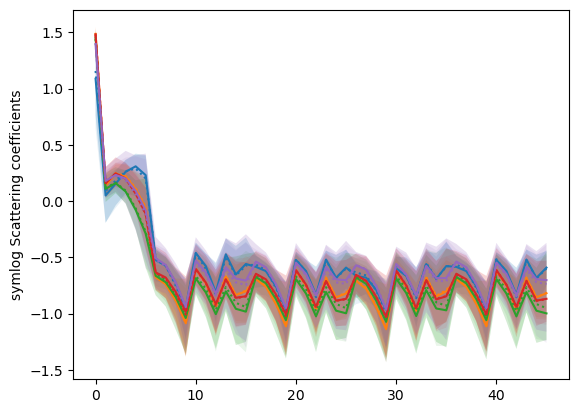

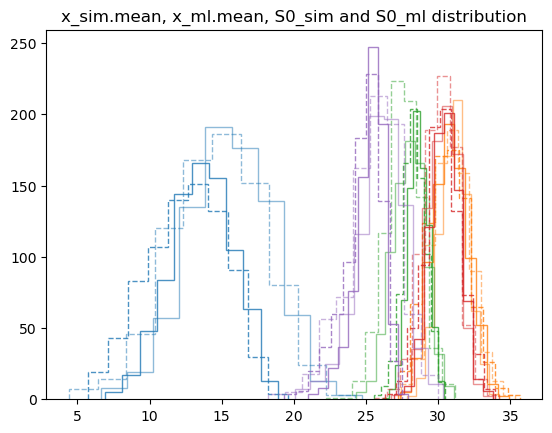

In [40]:
# num_list = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25600, 32000]
num_list = [5000]#[1600, 3200, 6400, 12800, 25600]
FSD_matrix = []
for num in num_list:
    # x0_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.400000095367432-zeta131.34100341796875-N{num}.npy")))
    # x1_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.599999904632568-zeta19.03700065612793-N{num}.npy")))
    # x2_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.698999881744385-zeta30.0-N{num}.npy")))
    # x3_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir5.4770002365112305-zeta200.0-N{num}.npy")))
    # x4_ml = rescale(torch.from_numpy(np.load(f"outputs/Tvir4.800000190734863-zeta131.34100341796875-N{num}.npy")))

    print("x.shape =", x0.shape, x0.mean(axis=(1,2,3)).shape)
    print("x0.min(), x0_ml.min() =", x0.mean(axis=(1,2,3)).min(), x0_ml.mean(axis=(1,2,3)).min())
    # print("x1.min(), x1_ml.min() =", x1.mean(axis=(1,2,3)).min(), x1_ml.mean(axis=(1,2,3)).min())
    # print("x2.min(), x2_ml.min() =", x2.mean(axis=(1,2,3)).min(), x2_ml.mean(axis=(1,2,3)).min())
    # print("x3.min(), x3_ml.min() =", x3.mean(axis=(1,2,3)).min(), x3_ml.mean(axis=(1,2,3)).min())
    # print("x4.min(), x4_ml.min() =", x4.mean(axis=(1,2,3)).min(), x4_ml.mean(axis=(1,2,3)).min())

    FSD_list = calculate_FSD_list(
        [
            (x0,x0_ml),
            (x1,x1_ml),
            (x2,x2_ml),
            (x3,x3_ml),
            (x4,x4_ml),
        ],
        params = [
            c0[0], 
            c1[0],
            c2[0], 
            c3[0], 
            c4[0],
        ],
        )
    FSD_matrix.append(FSD_list)

FSD_matrix = np.array(FSD_matrix)

(1, 1)


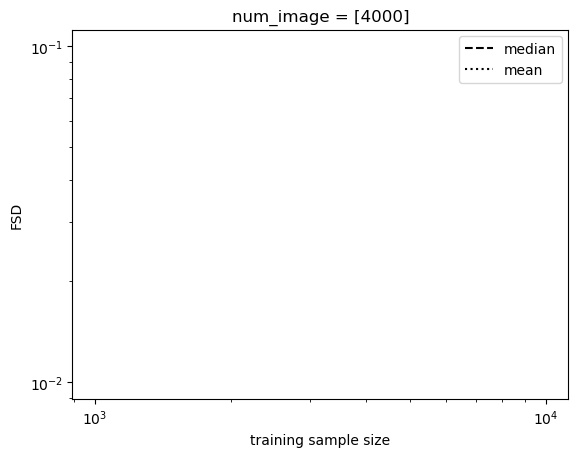

: 

In [ ]:
print(FSD_matrix.shape)
# print(FSD_matrix)
# num_list = [1000, 3000, 5000, 7000, 10000, 25600]
plt.plot(num_list, FSD_matrix, lw=0.5)
plt.plot(num_list, np.median(FSD_matrix, axis=-1), c='k', linestyle='--', label='median')
plt.plot(num_list, np.mean(FSD_matrix, axis=-1), c='k', linestyle=':', label='mean')
plt.xlabel("training sample size")
plt.ylabel("FSD")
plt.xscale('log')
plt.yscale('log')
plt.title(f"num_image = {num_list}")
# plt.xticks([1600,3200,6400,12800,25600])
# plt.xlim(xmin=3000)
plt.legend()
plt.show()

In [ ]:
import numpy as np
data = np.load('/storage/home/hcoda1/3/bxia34/p-jw254-0/ml21cm/outputs/Tvir4.400000095367432-zeta131.34100341796875-N2000-device0-0716-1726.npy')
print(data.shape)

In [ ]:
Tb = data[0,0]

In [ ]:
import matplotlib.pyplot as plt
for i in range(Tb.shape[-1]):
    plt.imshow(Tb[:,:,i])
    plt.savefig(f"Tb{i:03d}.png")

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# fnames = [f for f in os.listdir("outputs") if '0718' in f]
# print(fnames)

# images = []
# for fname in fnames:
#     image = np.load(os.path.join('outputs', fname))
#     print("image.shape =", image.shape)
#     images.append(image)

# images = np.concatenate(images, axis=0)
# print("images.shape =", images.shape)


['Tvir4.400000095367432-zeta131.34100341796875-N5000-device0-0718-2315.npy', 'Tvir4.400000095367432-zeta131.34100341796875-N5000-device3-0718-2314.npy', 'Tvir4.400000095367432-zeta131.34100341796875-N5000-device1-0718-2316.npy', 'Tvir4.400000095367432-zeta131.34100341796875-N5000-device2-0718-2314.npy']
image.shape = (20, 1, 64, 512)
image.shape = (20, 1, 64, 512)
image.shape = (20, 1, 64, 512)
image.shape = (20, 1, 64, 512)
images.shape = (80, 1, 64, 512)


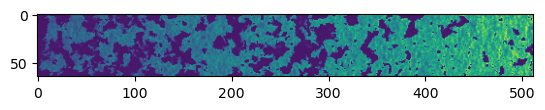

In [ ]:
plt.imshow(images[0,0])
plt.show()